# A Bayesian Home Run: Modeling a Successful Baseball Season
#### DS 6040 Final Project - Summer 2023
#### Dora Eskridge and Matt Scheffel (de2br, mcs9ff)

## Problem Statement:

   Since the 1800s, baseball has been a prominent feature of the American sports scene. Sports bring people together, and there is arguably no sport more universally understood and enjoyed in the United States than baseball. Everyone has a stake in the game, from the players and managers to the fans and the residents of the teams’ cities. While the fans have an emotional stake, players, managers, and franchise owners and employees stake their livelihood on their team’s success. Outside of the team itself, many Americans have a monetary stake in a given team’s success due to the prevalence of sports betting. Regardless of the driving force behind their interest, the undeniable truth is that millions of Americans follow major league baseball religiously each season, and the success of their favored team has a real impact on their lives.
	
   For any invested party, the ability to determine the success level of a given team for a given season is an invaluable asset. Through our analysis, we are seeking to determine the success rate of a team based on their game by game performance statistics. We will look at a series of in-game statistics from across several seasons, and we will investigate which of these statistics serve as useful predictors for the success rate of a baseball team. We will parse down to the most valuable predictors, and then we will determine how these predictors affect success rate. At the conclusion of our analysis, we aim to have constructed a model that will return an accurate report of a team’s seasonal success rate based on their in-game performance. In practice, this model could be used effectively in the postseason and the leadup to the world series– with a season’s worth of gameplay statistics, running two teams’ information through the model should indicate which team is more likely to win the series.

## Data Description:

For this analysis, we will be using a baseball database compiled by Sean Lahman. The database is extremely extensive, but we will be honing in on one specific data table for our analysis. The Teams data table provides a plethora of team-wide statistics from a wide range of seasons, dating back to the 1800s. 

The dataset includes many useful statistics: yearID, representing the year of the observation; lgID, representing league; teamID, representing team; franchID, representing franchise; divID, representing division; Rank, representing the teams final ranking at the end of the season; G, representing total games played in the season; Ghome, representing number of home games; W, representing wins; L, representing losses; DivWin, a binary variable representing whether the team won their division; WCWin, a binary variable representing whether the team won the Wild Card; LgWin, a binary variable representing whether the team won their league; WSWin, a binary variable representing whether the team won the World Series; R, representing the number of runs scored; AB, representing the number of at bats; H, representing the number of hits by batters; 2B, representing the number of doubles; 3B, representing the number of triples; HR, representing the number of home runs; BB, representing the number of walks; SO, representing the number of strikeouts; SB, representing the number of stolen bases; CS, representing the number of times the team was caught stealing; HBP, representing the number of times a batter was hit by a pitch; SF, representing the number of sacrifice flies; RA, representing the number of opponent runs scored; ER, representing the number of earned runs allowed; ERA, representing the earned run average; CG, representing the number of complete games; SHO, representing the number of shutouts; SV, representing the number of saves; IPOuts, representing the number of outs pitched; HA, representing the number of hits allowed; HRA, representing the number of home runs allowed; BBA, representing the number of walks allowed; SOA, representing the number of strikeouts by pitchers; E, representing the number of errors; DP, representing the number of double plays; FP, representing the fielding percentage; name, representing the team’s full name; park, representing the name of the team’s home ballpark; attendance, representing the home attendance total; BPF and PPF, representing the three-year park factor for batters and pitchers, respectively; and finally several teamID variables linking the Teams dataset to other datasets.

## Exploratory Data Analysis

In this section, we will perform data cleaning and analysis to help us understand the data and aid us in determining which variables will best suit our model.

In [83]:
# import necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

sns.set_context('notebook')
sns.set_style('white')

from pymc3 import get_data
from pymc3 import forestplot, traceplot, plot_posterior
# import as pm to work in Jupyter notebook
import pymc3 as pm

In [80]:
# import data

teams_data = pd.read_csv("Teams.csv")

# select limited timeframe and quantatative variables

teams_data = teams_data.loc[(teams_data['yearID'] >= 2005) & (teams_data['yearID'] <= 2015)]
teams_data = teams_data[['R', 'AB', 'H', '2B',
       '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA',
       'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'W']]

First, we take a look at the top 10 winningest teams in our database (which now ranges from 2005 to 2015), as well as the teams with the least wins to see if anything stands out.

### Figure 1.1

In [24]:
top_10 = teams_data.sort_values(by = 'W', ascending = False).head(10)
top_10

,R,AB,H,2B,3B,HR,BB,SO,SB,CS,...,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,W
2612,915,5660,1604,325,21,244,663,1014.0,111.0,28.0,...,51,4350,1386,181,574,1260,86,131,0.985,103
2675,713,5579,1409,258,38,153,539,1024.0,96.0,24.0,...,47,4431,1320,120,404,1299,74,135,0.988,102
2578,765,5540,1486,274,25,159,481,987.0,129.0,48.0,...,66,4354,1455,160,457,1106,91,159,0.985,100
2800,647,5484,1386,288,39,137,506,1267.0,69.0,38.0,...,62,4394,1359,123,477,1329,96,159,0.984,100
2500,805,5538,1494,287,26,170,534,947.0,83.0,36.0,...,48,4337,1399,153,443,974,100,196,0.984,100
2479,741,5529,1450,253,23,200,435,1002.0,137.0,67.0,...,54,4427,1392,167,459,1040,94,166,0.985,99
2757,773,5652,1464,304,31,155,492,1266.0,81.0,39.0,...,46,4448,1307,126,504,1342,83,127,0.986,98
2796,697,5631,1462,292,27,140,461,1322.0,98.0,45.0,...,54,4469,1392,110,453,1338,122,177,0.981,98
2714,731,5615,1468,301,25,194,479,1325.0,105.0,35.0,...,51,4405,1296,129,497,1325,94,134,0.985,98
2718,853,5651,1566,363,29,178,581,1308.0,123.0,19.0,...,33,4362,1366,156,524,1294,80,142,0.987,97


### Figure 1.2

In [26]:
bottom_10 = teams_data.sort_values(by = 'W').head(10)
bottom_10

,R,AB,H,2B,3B,HR,BB,SO,SB,CS,...,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,W
2725,610,5457,1307,266,16,148,426,1535.0,110.0,61.0,...,32,4320,1530,191,616,1084,125,168,0.979,51
2695,583,5407,1276,238,28,146,463,1365.0,105.0,46.0,...,31,4270,1493,173,540,1170,118,132,0.981,55
2666,615,5598,1442,309,28,95,401,1164.0,118.0,33.0,...,25,4305,1477,188,560,1191,116,140,0.981,56
2487,701,5503,1445,289,34,126,424,1008.0,53.0,33.0,...,25,4240,1640,178,580,924,125,163,0.979,56
2646,587,5386,1303,276,27,126,463,1207.0,87.0,36.0,...,31,4235,1567,167,538,1026,127,120,0.979,57
2624,710,5493,1416,271,38,156,617,1208.0,73.0,40.0,...,33,4273,1533,173,629,911,143,155,0.977,59
2594,641,5491,1376,269,26,117,534,1095.0,81.0,43.0,...,28,4302,1496,190,588,1063,123,143,0.980,59
2690,613,5411,1297,265,36,137,447,1235.0,94.0,45.0,...,28,4241,1399,175,573,1128,105,148,0.982,61
2648,513,5409,1274,227,16,101,459,1184.0,142.0,39.0,...,38,4314,1402,157,452,973,110,145,0.982,61
2531,689,5474,1395,267,33,190,441,1106.0,134.0,52.0,...,33,4261,1600,180,606,979,116,156,0.981,61


There are some interesting quick, eye-test observations from the data:

- The 4th "best" team (with the 4th most wins) in the dataset scored less runs than 4th "worst" team.
- The winningest teams are significantly "better" in the field, with only 2 teams entering triple digits in Errors (versus all 10 of the worst teams.)
- Teams who strike out less and walk more tend to rack up more wins. Patience is a virtue.

### Figure 1.3

<AxesSubplot:>

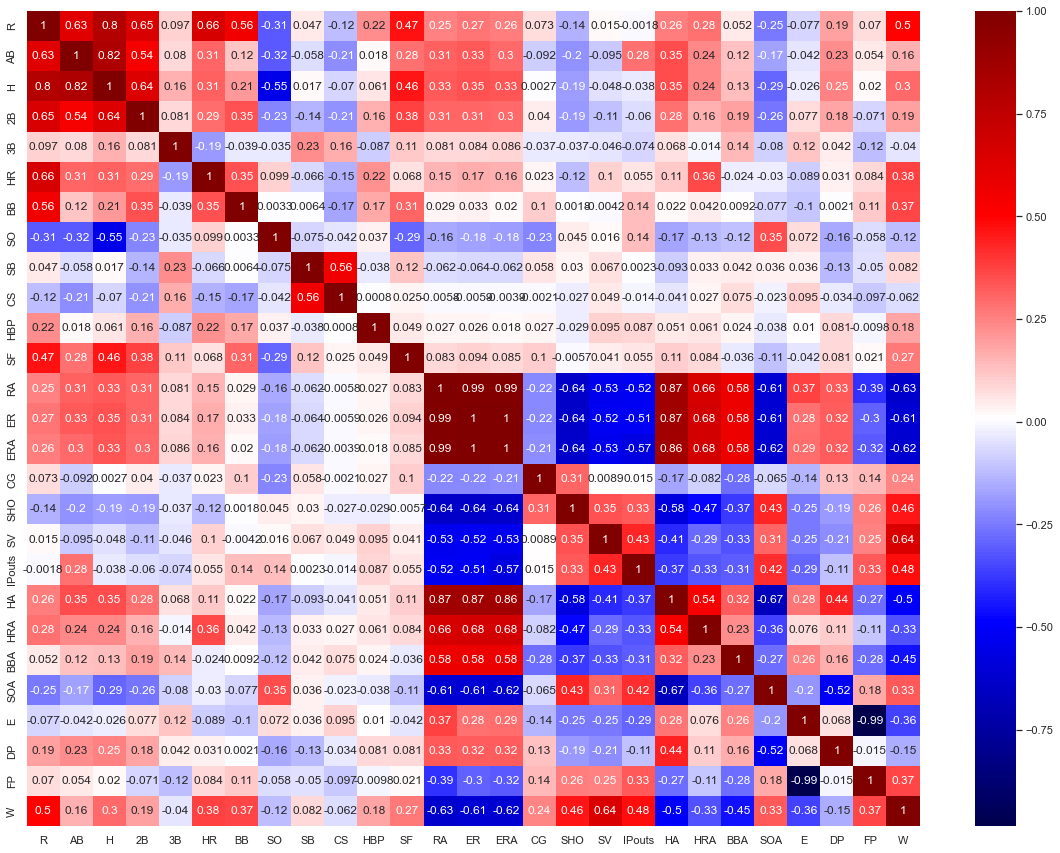

In [30]:
plt.subplots(figsize=(20,15))
sns.heatmap(teams_data.corr(), annot = True, cmap = "seismic")

Using an eye test from which variables look to have a particulary strong correlation (for or against) Wins, we can examine them further in a pairplot. We tended to skip over some that overlap or were redundant (such as Runs Allowed vs. Earned Runs Allowed.)

### Offense/Batting:

### Figure 1.4

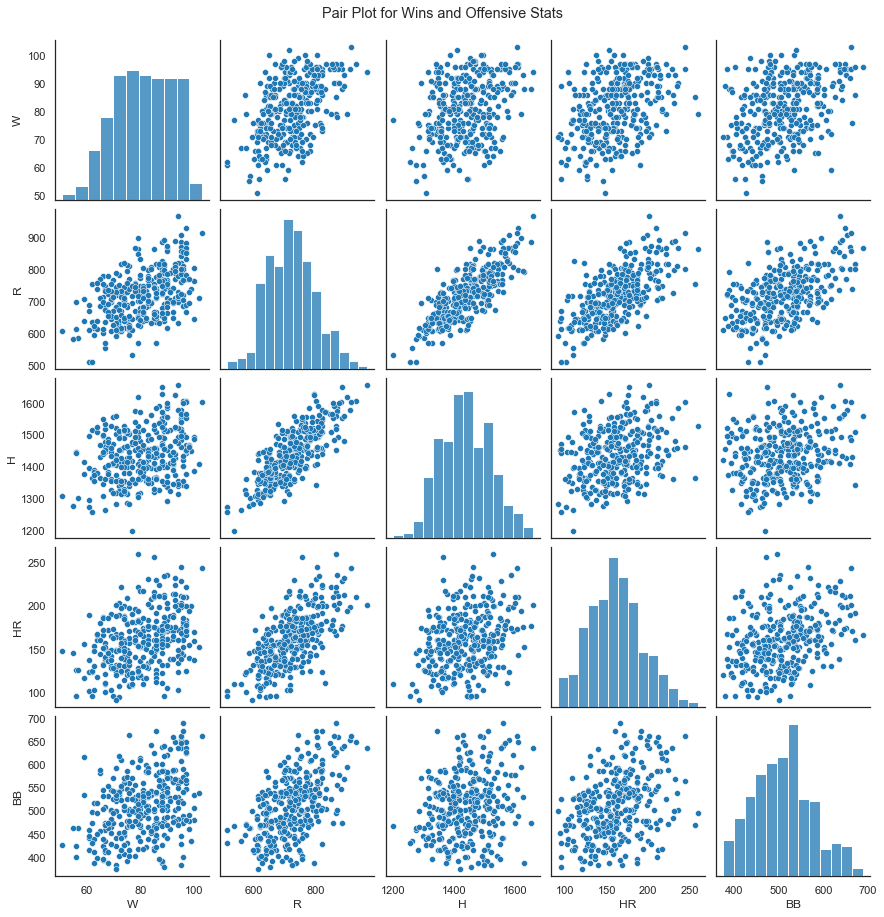

In [78]:
select_columns_O = ['W', 'R', 'H', 'HR', 'BB']
sns.pairplot(teams_data[select_columns_O])
plt.suptitle('Pair Plot for Wins and Offensive Stats', y = 1.02)
plt.show()

On the offensive side of the ball, Wins and Runs have the strongest correlation of the variables chosen. Interestingly, Home Runs just edge out Walks in correlation to Wins. Hits have a noticeable correlation with Wins, but the lowest amongst the group.

### Pitching/Defense:

### Figure 1.5

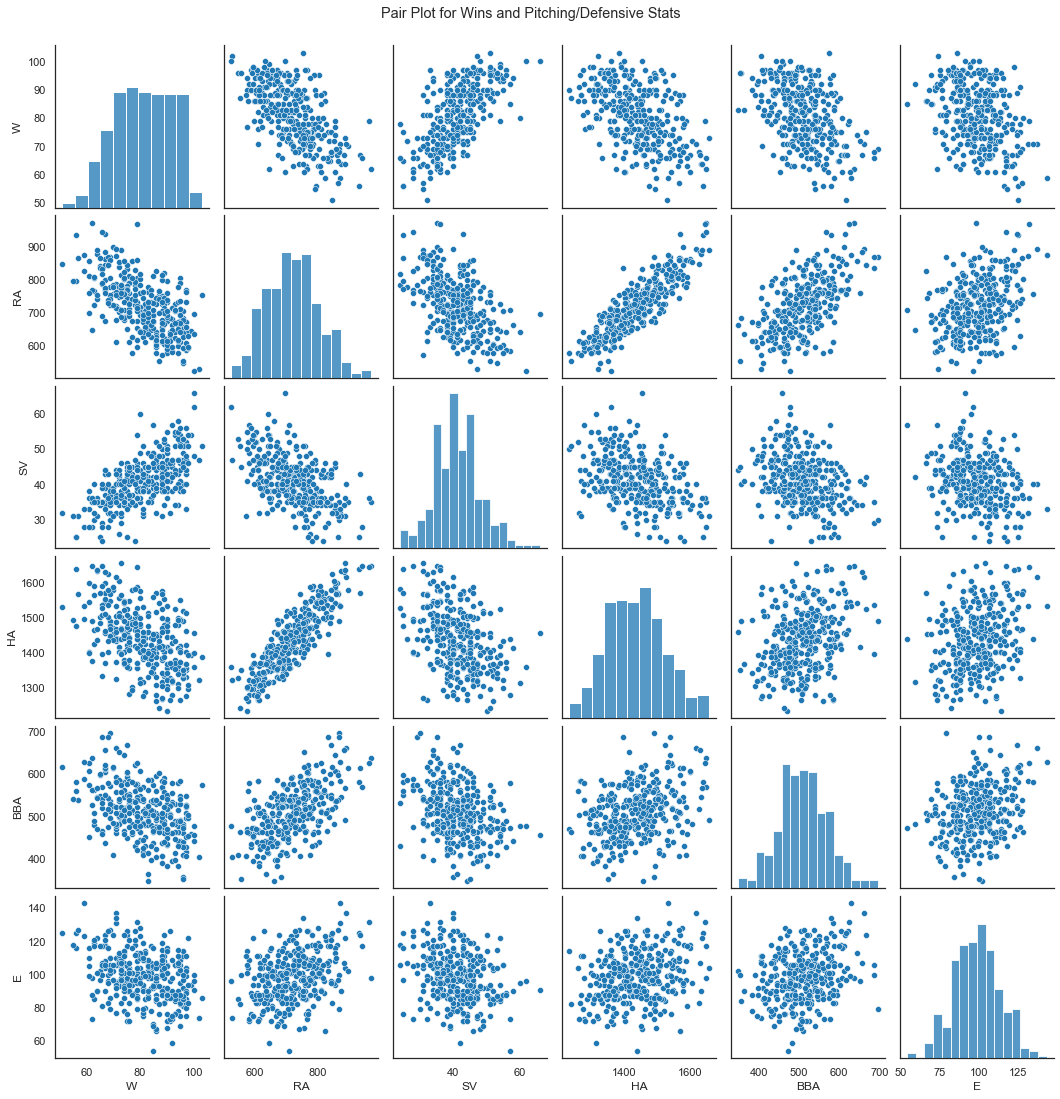

In [85]:
select_columns_D = ['W', 'RA', 'SV', 'HA', 'BBA', 'E']
sns.pairplot(teams_data[select_columns_D])
plt.suptitle('Pair Plot for Wins and Pitching/Defensive Stats', y = 1.02)
plt.show()

Overall, the pitching and defensive stats appeared to show stronger correlation with a baseball team's Wins. Saves had the strongest positive correlation with Wins, while Runs Allowed had the strongest negative correlation. This is no surprise, as in order to qualify for a Save, a pitcher must "enter the game with a lead of no more than three runs and pitch at least one inning; or enter the game with the tying run in the on-deck circle, at the plate or on the bases" according to MLB rules. This links save situations very closely to a team winning their game. On the other hand, letting the other team score a large amount of runs is typically not conducive to winning a game. Runs Allowed was followed by Hits Allowed, Walks Allowed, and Errors in terms of negative correlation.

We can see here the importance of runs and good pitching/defense in the following figure. As the amount of runs allowed by pitchers and the defense decreases, we see a significant trend towards winning more games:

### Figure 1.6

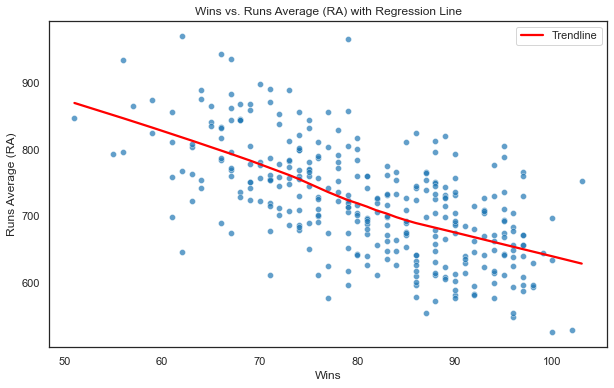

In [39]:
# Scatter Plot with Regression Line - Wins vs. RA

plt.figure(figsize=(10, 6))
sns.scatterplot(x='W', y='RA', data = teams_data, alpha=0.7)
sns.regplot(x='W', y='RA', data = teams_data, scatter=False, lowess=True, line_kws={'color': 'red'}, label='Trendline')
plt.xlabel('Wins')
plt.ylabel('Runs Average (RA)')
plt.title('Wins vs. Runs Average (RA) with Regression Line')
plt.legend()
plt.show()

#### Feature Importance:

Having finished examining our data, the main task that needs to be tackled before the final phase of model building is variable selection. With such a comprehensive dataset, parsing down the variables is extremely important for model performance and overall success. For this preliminary data work, we decided to use a random forest model to determine variable importance. 

We limited the variables included in the model to those that were collected on a game-by-game basis: R, AB, H, 2B, 3B, HR, BB, SO, SB, CS, HBP, SF, RA, ER, ERA, CG, SHO, SV, IPouts, HA, HRA, BBA, SOA, E, DP, FP, and W. 

To set up our random forest model, we created a training set and a test set in our data, where the training set was a random 70% split of the data and the test set was the remaining 30%. We set the value to be predicted as W, number of wins, as this will be our ultimate determinant of success in a given season. We ran the random forest model and updated the number of estimator trees from the default value of 100 to 200, so that we could have a higher level of accuracy. We also made sure to run it on the criterion specified by the Gini coefficient. We then fit the random forest model to our training data and extracted the relevant feature importances from the model to determine which features were most useful in determining the number of wins per season based on the Gini coefficient impurity. 

Figure 1.7 shows the fifteen most useful predictors and their respective importances.
	
Based on the random forest model variable importances, we chose to include the 5 most useful predictors in our final model. We decided to select 2 offensive-based stats (R and H), 2 pitching-based stats (SV and RA), and one defensive-based stat (E) to diversify and more fully capture the different aspects of the game. With this predictor set, the model will determine number of wins in a given season based on the following predictors: R, with an importance of .050062; H, with an importance of .044946; SV, with an importance of .044466; RA, with an importance of 0.040797; and E, with an importance of 0.038596. With this predictor set, we believe that our final model will predict the number of wins per season with a high level of accuracy.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(teams_data.iloc[:, :-1], 
                                                    teams_data.iloc[:, -1:], 
                                                    test_size = 0.3, 
                                                    random_state=7)

In [19]:
forest = RandomForestClassifier(n_estimators = 200,
                                criterion = 'gini',
                                random_state = 7)

forest.fit(X_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=200, random_state=7)

In [20]:
forest.feature_importances_

array([0.05006233, 0.04036112, 0.04494556, 0.03818125, 0.03833257,
       0.04143141, 0.04197864, 0.03741045, 0.03986503, 0.03719612,
       0.03572465, 0.02994008, 0.04079716, 0.03775771, 0.03743028,
       0.02749883, 0.0368077 , 0.04446599, 0.0405601 , 0.03546274,
       0.03941747, 0.04149062, 0.03826555, 0.0385961 , 0.03899276,
       0.02702779])

In [21]:
forest.feature_names_in_

array(['R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP',
       'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA',
       'BBA', 'SOA', 'E', 'DP', 'FP'], dtype=object)

### Figure 1.7

In [22]:
# feature importance

imps = list(zip(forest.feature_names_in_, forest.feature_importances_))
impsdf = pd.DataFrame(imps, columns = ['Feature', 'Importance'])
impsdf.sort_values(by = 'Importance', ascending = False)

,Feature,Importance
0,R,0.050062
2,H,0.044946
17,SV,0.044466
6,BB,0.041979
21,BBA,0.041491
5,HR,0.041431
12,RA,0.040797
18,IPouts,0.040560
1,AB,0.040361
8,SB,0.039865


# Model Description:

For our final analysis, we chose to construct a hierarchical Bayesian model.


Our equation will be:

$\hat{\text{Wins}} = 𝛼 + 𝛽 * runs + 𝛾 * hits + 𝛿 * saves + 𝜀 * runsallowed + 𝜁 * errors$

In this equation:

𝛽 represents the effect of runs for the team, indicating how much the number of Wins is expected to change with a one-unit increase in runs while keeping other variables constant.

𝛾 represents the effect of hits for the team, indicating how much the number of Wins is expected to change with a one-unit increase in hits while keeping other variables constant.

𝛿 represents the effect of saves for the team, indicating how much the number of Wins is expected to change with a one-unit increase in saves while keeping other variables constant.

𝜀 represents the effect of runs allowed for the team, indicating how much the number of Wins is expected to change with a one-unit increase in runs allowed while keeping other variables constant.

𝜁 represents the effect of errors for the team, indicating how much the number of Wins is expected to change with a one-unit increase in errors while keeping other variables constant.

𝛼 represents the hierarchical effect as well as the overall intercept, representing the baseline level of Wins at the mean levels of all variables.

### Prior Rationale:

𝜇 is set to follow a normal distribution with mean 0 and a large standard deviation of 10000. 𝜎 is set to follow a Half-Cauchy distribution with scale parameter 5. An offset is drawn from a normal distribution with mean 0 and standard deviation 1. The shape is 330. The coefficient  𝛼 is then determined as the sum of  𝜇 and each element of the offset vector multiplied by  𝜎. The motivation behind using such wide priors for  𝛼 is due to the lack of clear information or strong prior beliefs about its values. By employing these large priors, the model can maintain flexibility and allow for a more general representation of the posterior distributions.

For the remaining coefficients, the prior information is as follows:

An offset is drawn from a normal distribution with mean 0 and standard deviation 1. The coefficient of interest is determined as the value of the offset. These priors are chosen similarly to the 𝛼 priors because there is limited prior information about the data. There is no need for a shape input since the coefficients have similar structure.

Overall, these prior choices aim to account for uncertainty and avoid imposing strong assumptions on the coefficient values, allowing the model to be more flexible in representing the data's behavior.

# Code:

In [43]:
# needed to set these as values to avoid indexing errors

wins = teams_data.W.values
runs = teams_data.R.values
hits = teams_data.H.values
saves = teams_data.SV.values
runsallowed = teams_data.RA.values
errors = teams_data.E.values

In [69]:
with pm.Model() as hierarchical_model:
    # Priors for the fixed effects
    # a - overall intercept, baseline level of Wins at mean levels of all variables
    mu_a = pm.Normal('mu_a', mu=0., sd=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    
    # Wins intercepts as offsets
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=330)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)
    
    # effect of runs for the team
    beta_runs = pm.Normal('beta_runs', mu=0., sd=1e5)
    # effect of hits for the team
    gamma_hits = pm.Normal('gamma_hits', mu=0., sd=1e5)
    # effect of saves for the team
    delta_saves = pm.Normal('delta_saves', mu=0., sd=1e5)
    # effect of runs allowed for the team
    epsilon_runs_allowed = pm.Normal('epsilon_runs_allowed', mu=0., sd=1e5)
    # effect of errors for the team
    zeta_errors = pm.Normal('zeta_errors', mu=0., sd=1e5)
    
    # Residual Error
    res_error = pm.HalfCauchy('res_error', 5)
    
    # This is the specification for the regression equation itself.
    wins_reg = a + beta_runs * runs + gamma_hits * hits + delta_saves * saves + epsilon_runs_allowed * runsallowed + zeta_errors * errors

    # Data likelihood
    wins_likelihood = pm.Normal('wins_likelihood', mu = wins_reg, sd = res_error, observed = teams_data.W)

In [70]:
with hierarchical_model:
    hierarchical_trace = pm.sample(1000, n_init = 50000, tune = 1000)

/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [res_error, zeta_errors, epsilon_runs_allowed, delta_saves, gamma_hits, beta_runs, a_offset, sigma_a, mu_a]


/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `targe

In [71]:
baseball_summary = pm.summary(hierarchical_trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


### Figure 1.8

In [81]:
baseball_summary = baseball_summary.reset_index()
baseball_summary = baseball_summary.query("index.str.contains('mu_a|beta_runs|gamma_hits|delta_saves|epsilon_runs_allowed|zeta_errors', case=False)")
baseball_summary.sort_values('mean', ascending=False)

,index,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,mu_a,56.298,4.197,48.409,64.787,0.208,0.158,502.0,158.0,1.01
333,delta_saves,0.455,0.032,0.396,0.516,0.002,0.001,474.0,147.0,1.01
331,beta_runs,0.090,0.004,0.082,0.097,0.000,0.000,469.0,191.0,1.01
332,gamma_hits,-0.000,0.004,-0.007,0.007,0.000,0.000,747.0,319.0,1.01
335,zeta_errors,-0.002,0.013,-0.027,0.021,0.000,0.000,1367.0,2466.0,1.00
334,epsilon_runs_allowed,-0.082,0.003,-0.087,-0.076,0.000,0.000,408.0,134.0,1.01


A few takeaways from these findings:

- Consistent r-hat values around 1 suggest that our sampler performed well, meaning that the sampler has explored the parameter space effectively and provides reliable estimates for the model parameters.
- The ESS values also indicate that the chains look to have converged well for these parameters.
- Standard deviation values appear to have remained relatively low.

# Results

Our hierarchical Bayesian model was used to test the variables influencing team performance in baseball. The estimated mean baseline level of a team's wins, mu_a, represented the expected number of wins at the average levels of all the variables that were included in our model: runs, hits, saves, runs allowed, and errors. The resulting mean was approximately 56.3, with a moderate standard deviation of 4.197. 

The effects of specific variables on team wins were also determined. The number of saves was found to have the greatest positive effect, with an estimated effect size of 0.455 and relatively low uncertainty (a standard deviation of 0.032). Similarly, runs scored demonstrated a positive impact, with an effect size of 0.090 and low uncertainty (a standard deviation equal to 0.004). 

Interestingly, hits seemed to have a negligible effect on wins, with the estimated effect being close to zero. 

On the other side, errors were associated with a slight negative impact as the effect size was -0.002, but the uncertainty in this estimate was relatively higher (with a standard deviation of 0.013). Unsurprisingly, runs allowed exhibited the strongest negative effect, with a notable effect size of -0.082 and low uncertainty (standard deviation = 0.003). These findings provide insights into the factors driving team performance and could inform strategies for optimizing team success in baseball.

# Discussion

Based on our model, the selected pitching stats seem to play a larger role in determining the outcome of the game than the selected offensive stats. The positive effect of saves on wins suggests that teams which are more successful in preserving their tight leads and securing victories in close games tend to have a higher overall win count. This emphasizes the critical role of a strong bullpen and effective closing pitchers in securing wins for a baseball team. Similarly, the negative effect of runs allowed reinforces the critical role of strong pitching and effective defensive strategies. The model suggests that teams which can limit their opponents' scoring are more likely to secure victories, indicating that a solid pitching rotation and reliable defense are important aspects of success for a baseball team.

Of course, that does not mean that offense is completely worthless. The positive effect of runs scored emphasizes the significance of offense in driving team success. Teams that can consistently score runs are more likely to secure wins, indicating the importance of a well-rounded batting lineup and effective run-scoring strategies. These run-scoring strategies can come in many ways - as evidenced by the finding that hits have a negligible effect on wins in our model. The finding suggests that numerous methods for getting on base can contribute to run scoring strategies and that the quality of hits may be more important than the quantity of hits when it comes to winning games.

Overall, our model appears to give useful insight into the strategies that go into creating a successful, winning baseball team.

# Appendix

### Trace Plots

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'a_offset'}>,
        <AxesSubplot:title={'center':'a_offset'}>],
       [<AxesSubplot:title={'center':'beta_runs'}>,
        <AxesSubplot:title={'center':'beta_runs'}>],
       [<AxesSubplot:title={'center':'gamma_hits'}>,
        <AxesSubplot:title={'center':'gamma_hits'}>],
       [<AxesSubplot:title={'center':'delta_saves'}>,
        <AxesSubplot:title={'center':'delta_saves'}>],
       [<AxesSubplot:title={'center':'epsilon_runs_allowed'}>,
        <AxesSubplot:title={'center':'epsilon_runs_allowed'}>],
       [<AxesSubplot:title={'center':'zeta_errors'}>,
        <AxesSubplot:title={'center':'zeta_errors'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'res_error'}>,
   

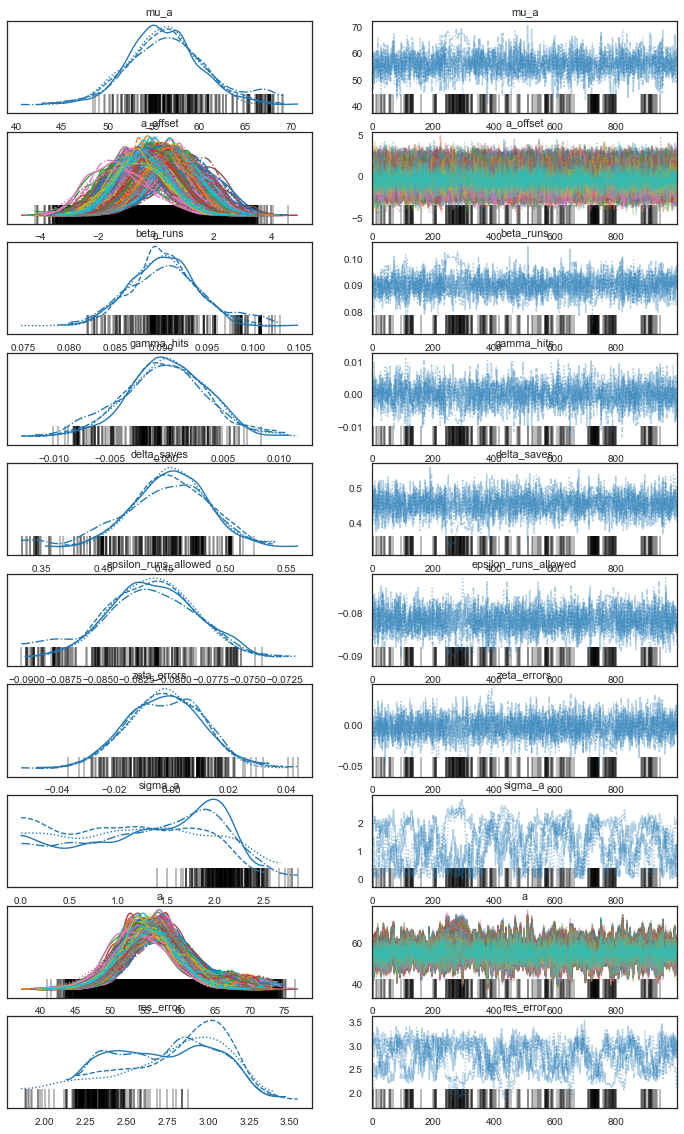

In [82]:
pm.plot_trace(hierarchical_trace)

/var/folders/9s/pz872p91741110p_4gz6llzc0000gn/T/ipykernel_32523/23378967.py:2: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  forestplot(hierarchical_trace, var_names=['a'])
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

<Figure size 432x1008 with 0 Axes>

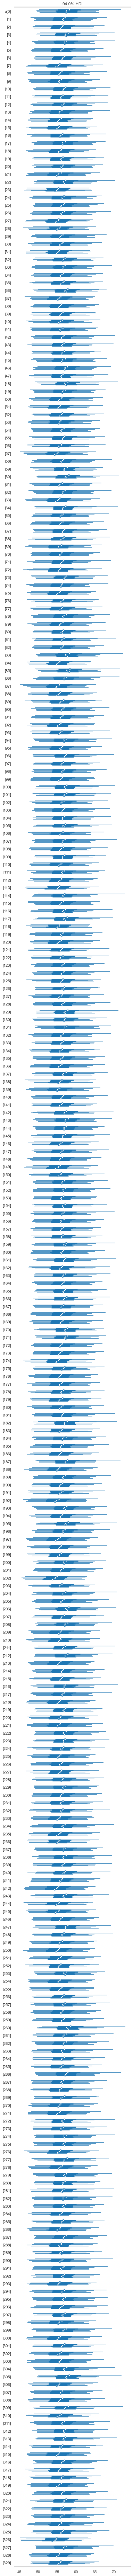

In [84]:
plt.figure(figsize=(6,14))
forestplot(hierarchical_trace, var_names=['a'])